For this notebook follow:

- do not use zsh_profile
- source ~/.bashrc
- module load hess_hap
- module load mysql
- do not open the jupyter how you usually do
- open a new session of jupyter

In [1]:
#!module load hess_hap
# !module load python/3.6-anaconda

In [2]:
import numpy as np
from haptools.runselector import RunSelector

In [3]:
hesseras = ['hess1', 'hess2']

for hessera in hesseras:
    rs = RunSelector(ecap=True)    
    if hessera == 'hess2':
        rs = RunSelector(ecap=True, hess2=True)
    rs.query_table_data('Monitor_Run_Atmosphere')#, runs=sel_q.index)
    data = rs.data.Monitor_Run_Atmosphere['TransparencyCoefficient_mean']#.loc[sel_q.index]
    
    full_save = []
    full_save.append(np.asarray(data.index))
    full_save.append(np.asarray(data.array))
    
    np.savetxt(f'TC_{hessera}.txt', np.asarray(full_save))

# testing the TC for different datasets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from gammapy.modeling.models import Models

In [2]:
colors = ['darkblue', 'C0', 'C1', 'C2', 'C5']
hesseras=['hess1', 'hess2', 'hess1u']
central_source='HESS J1745-290'

In [3]:
runlists = []
TCs_full = []
for hessera in hesseras:
    if hessera == 'hess1':
        for idx in range(3):
            runlists.append(np.loadtxt(f'../runlist_{hessera}_{idx}.txt'))
    else:
        runlists.append(np.loadtxt(f'../runlist_{hessera}.txt'))   
        
    if hessera != 'hess1u':
        TCs_full.append(np.loadtxt(f'TC_{hessera}.txt'))

In [4]:
TCs = []
for idx, runlist in enumerate(runlists):
    if idx <3:
        TC_aux = TCs_full[0]
    else:
        TC_aux = TCs_full[1]
    mask=[True if obsid in runlist else False for obsid in TC_aux[0]]
    TCs.append(TC_aux[:, mask])

Text(0.5, 0, 'TC')

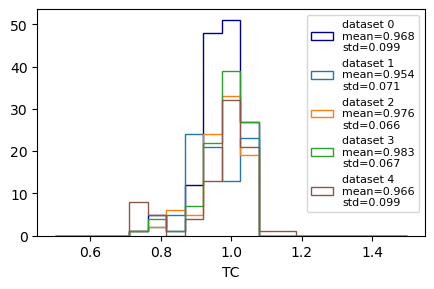

In [5]:
fig, ax = plt.subplots(1,1, figsize=(5, 3), dpi=100)

for idx in range(5):
    data= TCs[idx][1]
    ax.hist(data, histtype='step', color=colors[idx], bins=np.linspace(0.5,1.5,20), 
             label=f'dataset {idx}\nmean={np.mean(data):.3f}\nstd={np.std(data):.3f}')
ax.legend(fontsize=8)
ax.set_xlabel('TC')

In [6]:
muoneff_flag= True
edisp = True

info_list = [] #hessera, muoneff, edisp, name
mainpath_hess = '/home/vault/caph/mppi062h/repositories/GC/HESS'

for hessera in hesseras:
    if hessera =='hess1u':
        muoneff_flag=False
        
    if hessera == 'hess1':
        name_afterFermi='v1'
        for name_afterFermi_idx in range(3):
            name = f'20220702_{hessera}_muoneff{muoneff_flag}_edisp{edisp}_afterFermi{name_afterFermi}_{name_afterFermi_idx}'
            info_list.append([hessera, muoneff_flag, edisp, name])
    else:
        name = f'20220702_{hessera}_muoneff{muoneff_flag}_edisp{edisp}'
        info_list.append([hessera, muoneff_flag, edisp, name])

In [7]:
models_list = []
for idx in range(5):
    model_path = f'../fitted_model_{info_list[idx][3]}.yml'
    if os.path.exists(model_path):
        models_list.append(Models.read(model_path))

Text(0.5, 1.0, 'E_cutoff in function of mean TC')

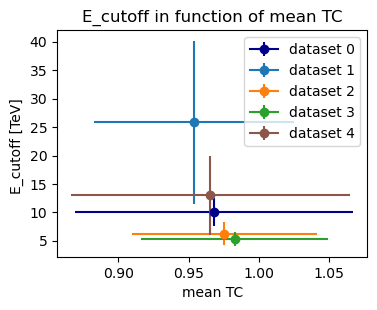

In [9]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

for idx, models in enumerate(models_list):
    data_tc= TCs[idx][1]
    
    label=f'dataset {idx}'
    par='lambda_'
    e_cutoff = 1/models[central_source].spectral_model.parameters[par].value
    e_cutoff_error = e_cutoff**2*models[central_source].spectral_model.parameters[par].error
    plt.errorbar(np.mean(data_tc), e_cutoff, xerr=np.std(data_tc),
                 yerr=e_cutoff_error,
                 color=colors[idx], label=label, marker='o')
    
ax.set_xlabel('mean TC')
ax.set_ylabel('E_cutoff [TeV] ')
plt.legend()
plt.title(f'E_cutoff in function of mean TC')

In [15]:
import yaml
from gammapy.data import DataStore

hesseras = ['hess1', 'hess2', 'hess1u']
with open("/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/general_config.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
conf=cfg['conf']

def get_table(runlist, hessera):
    basedir = f'$FITS_PROD/{hessera}/std_{conf}_fullEnclosure'
    ds = DataStore.from_dir(basedir, f'hdu-index-bg-latest-fov-radec.fits.gz', f'obs-index-bg-latest-fov-radec.fits.gz')
    obs_table = ds.obs_table

    mask = [True if obsid in runlist else False for obsid in obs_table['OBS_ID']]
    obs_table=obs_table[mask]
    return obs_table

full_info = []
for hessera in hesseras:
    name_afterFermi = 'v1'
    if hessera == 'hess1':
        for idx in range(3):
            runlist = np.loadtxt(f'../runlist_{hessera}_{idx}.txt')
            full_info.append(get_table(runlist, hessera))
    else:
        runlist = np.loadtxt(f'../runlist_{hessera}.txt')
        full_info.append(get_table(runlist, hessera))

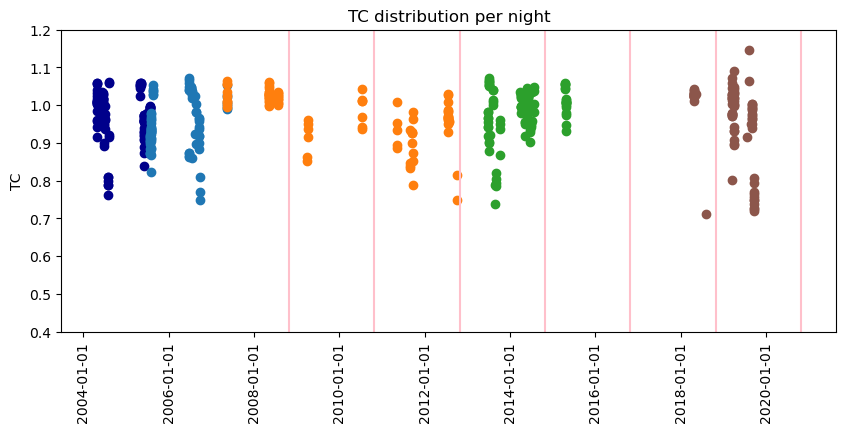

In [24]:
import datetime
import matplotlib.dates as mdates

day = '27'
month = '10'
time_label=['2008-2010', '2010-2012', '2012-2014', '2014-2016', '2016-2018', '2018-2020', '2020-2022']
N_bin_met = 8

colors = ['darkblue', 'C0', 'C1', 'C2', 'C5']

fig, ax = plt.subplots(1,1, figsize=(10, 4), dpi=100)

for i, table in enumerate(full_info):
    list_date = []
    for j in range(len(table)):
        list_date.append([table['DATE-OBS'][j], TCs[i][1,j]])
    list_date = np.asarray(list_date)
    
    x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in list_date[:, 0]]
        
    formatter = mdates.DateFormatter("%Y-%m-%d")    
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.YearLocator(2)
    ax.xaxis.set_major_locator(locator)

    ax.scatter(x_values, list_date[:, 1].astype(float), label=f'dataset {i}', color=colors[i])
    
for n_bin_met in range(N_bin_met-1):
    if n_bin_met == N_bin_met-1:
        edge=datetime.datetime.strptime(f'{time_label[n_bin_met][5:]}-{month}-{day}',"%Y-%m-%d").date()
    else:
        edge=datetime.datetime.strptime(f'{time_label[n_bin_met][:4]}-{month}-{day}',"%Y-%m-%d").date()
    label = None
    if n_bin_met == 0:
        label='fermi time bin edges'
    ax.axvline(edge, color='pink', label=label)
    
plt.xticks(rotation=90)
plt.ylabel('TC')
plt.title('TC distribution per night')
plt.ylim(0.4,1.2)
#plt.legend()
plt.show()

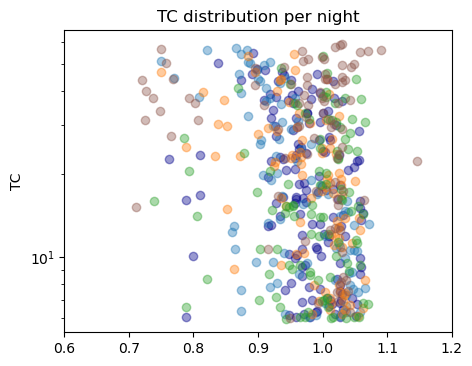

In [38]:
fig, ax = plt.subplots(1,1, figsize=(5, 4), dpi=100)

for i, table in enumerate(full_info):
    list_date = []
    for j in range(len(table)):
        list_date.append([TCs[i][1,j], table['ZEN_PNT'][j]])
    list_date=np.asarray(list_date)
    ax.scatter(list_date[:, 0], list_date[:, 1], label=f'dataset {i}', color=colors[i], alpha=0.4)
    
    
plt.ylabel('TC')
plt.title('TC distribution per night')
plt.xlim(0.6,1.2)
plt.yscale('log')
#plt.legend()
plt.show()